In [4]:

import numpy as np
import pandas as pd

from Preprocessing import Preprocessing
from Problem import Problem
from LocalSearch import LocalSearch
from SM import SM
from ModSM import ModSM

from helpers  import getSingleExp_df
import matplotlib.pyplot as plt

In [2]:
#Path to input file, before trimming
inputFilename = 'bet-sum18.xml'
problem = Problem(inputFilename)


1239 Classes extracted
665 Subparts extracted
340 Courses extracted
657 Hard Constraints extracted
3 Soft Constraints extracted
1641 Students extracted
Random solution initiated.


In [19]:
ls = getSingleExp_df(EID='LS_1627160876', columns='Iteration, Best_SP')
sm = getSingleExp_df(EID='SM_1627161216', columns='Iteration, Best_SP')
msm = getSingleExp_df(EID='MSM_1627163721', columns='Iteration, Best_SP')

In [20]:
combined = pd.DataFrame()
#combined['Iteration'] = ls['Iteration']
combined['Local_Search'] = ls['Best_SP']
combined['SM'] = sm['Best_SP']
combined['Modified_SM'] = msm['Best_SP']

combined.cumsum()

,Local_Search,SM,Modified_SM
0,196560,201360,189900.0
1,393120,402720,359580.0
2,584880,604080,529260.0
3,776640,800640,698940.0
4,963600,992400,868620.0
...,...,...,...
19996,2686792500,2799968520,NaN
19997,2686926780,2800102800,NaN
19998,2687061060,2800237080,NaN
19999,2687195340,2800371360,NaN


In [23]:
msm.to_csv('msmout.csv')

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

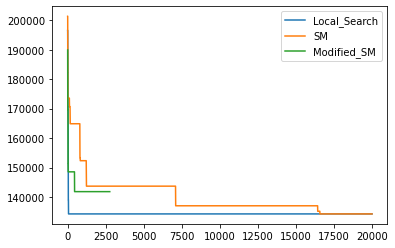

In [21]:
plt.figure()

combined.plot()

In [ ]:
mod_sm = ModSM(budget=20000, stopping_sp=500, 
                initial_temp=1.0, age_limit=5,
                local_timeout_limit=5, rw_limit=10,
                steps=5, beta=float(6e-4), gamma = float(1e-4),
                problem= problem, group='BetSum18_20K')


In [ ]:
mod_sm.solve()

In [ ]:
ls = LocalSearch(budget=20000, stopping_sp=500, problem= Problem(inputFilename), group='agh-fis-spr17_20K')

In [ ]:
sm = SM(budget=20000, stopping_sp= 500, initial_temp= float(1),
        beta= float(6e-4), gamma = float(1e-4),
        problem= problem, group='agh-fis-spr17_20K')
sm.solveAsync()

In [ ]:
problem = Problem('agh-fis-spr17.xml')
sm = SM(budget=1000, stopping_sp= 500, initial_temp= float(1),
        beta= float(6e-4), gamma = float(1e-4),
        problem= problem, group='SMvsIterations')
sm.solveAsync()

In [6]:
import threading
threading.activeCount()

6

In [8]:


for thread in threading.enumerate():
    print(thread.getName())

MainThread
Thread-2
Thread-3
IPythonHistorySavingThread
Thread-1
Thread-5


In [9]:

from google.cloud import bigquery

bqclient = bigquery.Client()


   Iteration  Best_SP
0          0   196560
1          1   196560
2          2   191760
3          3   191760
4          4   186960


In [ ]:
# Generating pandas df for local search
lst_str_cols = ['EID', 'Iteration',  'Best_SP']
# use dictionary comprehension to make dict of dtypes
dict_dtypes = {x : 'str'  for x in lst_str_cols}
df = pd.DataFrame(columns=lst_str_cols)
df.astype(str)

In [ ]:
from google.cloud import firestore

# The `project` parameter is optional and represents which project the client
# will act on behalf of. If not supplied, the client falls back to the default
# project inferred from the environment.
# db = firestore.Client.from_service_account_json('C:\\Users\\Acer\\Documents\\GitHub\\university-time-scheduling\\utp-320721-e1afef9ba011.json')

from time import time 

params = {}
params['EID'] = f'LS_{int(time())}'
params['BUDGET'] = 10
params['STOPPING_SP'] = 5000
params['type'] = 'Local Search'

# doc_ref = db.collection('experiments').document(params['EID'])
# doc_ref.set(params)

In [ ]:
#Trims the input file and outputs the trimmed filename
outputfile = Preprocessing.getTrimmedFile(inputFilename)

In [ ]:
#Extracts the data from trimmed file
courses, subparts, classes, hardConstraints, softConstraints, students = Preprocessing.extractData(outputfile)

In [ ]:
import random

# This loop assigns a random index and the number of available times for each class. This is stored as a tuple in a dictionary using classID as key. This index is always less than the number of timings available with each class.

initial_solution = {}

for classID in classes.keys():
    initial_solution[classID] = (random.randrange(len(classes[classID].availTimes)), len(classes[classID].availTimes))
    #print(solution_template[classID])

In [ ]:
#Check for two timings for DifferentTime constraints
def getSameTimeslots(timing1, timing2):
    #getting start and end times for both timings
    t1start = int(timing1.start)
    t2start = int(timing2.start)
    t1end = t1start + int(timing1.length)
    t2end = t2start + int(timing2.length)

    #Total overlap in time regardless of day or week
    overlapLength = 0

    #Calculates the daily overlap if classes occur at any same day
    if(t1end >= t2start):
        overlapLength = t1end - t2start + 1
    elif(t2end >= t1start):
        overlapLength = t2end - t1start + 1

    #print(f"Overlapping timeslots: {overlapLength}")
    #Returns the overlap length
    return overlapLength

In [ ]:
#Check for timings for DifferentDay timings 
def getSameDays(timing1, timing2):
    #getting days data from both timings
    t1d = list(timing1.days)
    t2d = list(timing2.days)

    #Count for days overlapped
    count = 0
    #Iterate through all days of the the week
    for i in range(0, 7):
        #Checks if class occur on the same day at any day of the semester
        if (t1d[i] == t2d[i]) and (t1d[i]==1):
            #Add one to days overlapped
            count = count + 1

    #print(f"Overlapping days: {count}")
    #return number of days the classes occur on the same day
    return count

In [ ]:
#function to check if 2 timings are overlapping
def isOverlapped(timing1, timing2):
    #getting start and end times for both timings
    t1start = int(timing1.start)
    t2start = int(timing2.start)
    t1end = t1start + int(timing1.length)
    t2end = t2start + int(timing2.length)
    #Count of overlapping days
    count = 0

    
    #number of 5-min timeslots overlapped
    dailyOverlap = 0

    #this if is to check if the time of the classes are overlapping. 
    #classes will overlap only if the time of the class overlap on any day
    if (t1end >= t2start) or (t2end >= t1start):
        #interate through all days of the semester
        for i in range(0, timing1.tdays_np.size):
            #Checks if class occur on the same day at any day of the semester
            if (timing1.tdays_np[i] + timing2.tdays_np[i]) == 2:
                #Add one to days overlapped
                count = count + 1
        #Calculates the daily overlap if classes occur at any same day
        if(count>0):
            if(t1end >= t2start):
                dailyOverlap = t1end - t2start + 1
            elif(t2end >= t1start):
                dailyOverlap = t2end - t1start + 1

    #Total 5-min timeslots overlapped in a semester
    violations = count*dailyOverlap
    #print(f"Total timeslot overlaps: {violations}, daily overlap: {dailyOverlap}, days overlapped: {count}")
    return violations, dailyOverlap, count

In [ ]:
from itertools import combinations
#Get Hard penalty
def getHardPenalty(solution):
    #Total violations for all constraints
    totalHardViolations = 0

    #Iterating all hard constraints
    for hard in hardConstraints:
        #Check if type is 'NotOverlap'
        if hard.type == 'NotOverlap':

            #Getting list of classes for the corresponding constraint
            classList = hard.classes
            
            #Getting all possible pairs from the list
            pairs = list(combinations(classList, 2)) 
            
            singleConstraintViolation = 0
            #Iterating through all the pairs
            for pair in pairs:
                #Unpacking thepair
                class1ID, class2ID = pair
                #Extracting class timings
                class1Index,_ = solution[class1ID]
                class2Index,_ = solution[class2ID]
                class1Timing = classes[class1ID].availTimes[class1Index]
                
                class2Timing = classes[class2ID].availTimes[class2Index]

                #Getting 'NonOverlap' violations
                violations, dailyOverlap, count = isOverlapped(class1Timing, class2Timing)
                
                #Adding to total violations
                singleConstraintViolation = singleConstraintViolation + violations
           
            if(singleConstraintViolation>0):
                hard.satisfied = False
            else:
                hard.satisfied = True
           

            totalHardViolations = totalHardViolations + singleConstraintViolation
    #print(f"Total Hard penalty: {totalHardViolations}")
    return totalHardViolations    
            

        

In [ ]:
#Get soft penalty
def getSoftPenalty(solution):
    #Total violations for all constraints
    totalSoftPenalty = 0

    #Iterating all hard constraints
    for soft in softConstraints:
        #Getting list of classes for the corresponding constraint
        classList = soft.classes
        penalty = soft.penalty
            
        #Getting all possible pairs from the list
        pairs = list(combinations(classList, 2)) 
            
        constraintTotal = 0
        #Iterating through all the pairs
        for pair in pairs:
            #Unpacking thepair
            class1ID, class2ID = pair
            #Extracting class timings
            class1Index,_ = solution[class1ID]
            class2Index,_ = solution[class2ID]
            class1Timing = classes[class1ID].availTimes[class1Index]
            class2Timing = classes[class2ID].availTimes[class2Index]

            #Check for 'DifferentTime'
            if(soft.type == 'DifferentTime'):
                overlaps = getSameTimeslots(class1Timing, class2Timing)
                constraintTotal = constraintTotal + (overlaps*penalty)
            
            #Check for 'DifferentDays'
            elif(soft.type == 'DifferentDays'):
                count = getSameDays(class1Timing, class2Timing)
                constraintTotal = constraintTotal + (count*penalty)

        if(constraintTotal>0):
            soft.satisfied = False
        else:
            soft.satisfied = True

        #Adding to total soft penalty after multiplying with penalty corresponding to that soft constraint
        totalSoftPenalty = constraintTotal*int(soft.penalty)



    #print(f"Soft Penalty: {totalSoftPenalty}")
    return totalSoftPenalty


In [ ]:
#Get penalty of timings
def getTimingPenalty(solution):
    #Timing penalty calculation
    totalTimingPenalty = 0

    #Iterating through all the classes
    for classID in classes.keys():
        #Getting selected timing from each class
        selectedIndex,_ = solution[classID]
        selectedTiming = classes[classID].availTimes[selectedIndex]
        #Adding penalty of selected timing to total timings penalty
        totalTimingPenalty = totalTimingPenalty + int(selectedTiming.penalty)

    #print(f"Timing Penalty: {totalTimingPenalty}")
    return totalTimingPenalty

In [ ]:
# Function to mutate a given solution
def mutate(solution):
    mutation = solution.copy()
    #Creating a list of keys(classIDs)
    indexList = list(mutation.keys())
    #Getting a random classID from the list
    randomClass = indexList[random.randrange(len(indexList))]
    #print(solution)
    #Extracting the timing info of that class
    timingIndex,timingsLen = mutation[randomClass]

    #Reducing the probabilty of not having a mutation. If a class is selected with a single timing, mutation is not possible. 
    if timingsLen == 1:
        for i in range(10):
            randomClass = indexList[random.randrange(len(indexList))]
            timingIndex,timingsLen = mutation[randomClass]
            if(timingsLen>1):
                break
    #Mutating the index
    if(timingsLen != 1):
        newIndex = (timingIndex+random.randrange(timingsLen-1)+1)%timingsLen
        mutation[randomClass] = (newIndex, timingsLen)
        #print(f"Mutating class {randomClass} from timing index {timingIndex} to {newIndex} out of {timingsLen} timings")
    else:
        print('No mutation')

    #Replacing the dictionary value
    
    #print(solution)
    return mutation


In [ ]:

#Incrementing interations and timeout counts in constraints
def ageConstraints(timeout):
    for hard in hardConstraints:
        if(hard.satisfied):
            hard.iterations = 0
            hard.timeouts = 0
        else:
            hard.iterations = hard.iterations + 1
            if(timeout):
                hard.timeouts = hard.timeouts + 1
    for soft in softConstraints:
        if(soft.satisfied):
            soft.iterations = 0
            soft.timeouts = 0
        else:
            soft.iterations = soft.iterations + 1
            if(timeout):
                soft.timeouts = soft.timeouts + 1

#Scales the constriants if they are unsatisfied #1.01
#MC = 1.01
def scaleConstraints(MC):
    # for hard in hardConstraints:
    #     if(hard.satisfied == False):
    #         hard.scale = hard.scale * MC
  
    for soft in softConstraints:
        if(soft.satisfied == False):
            soft.scale = soft.scale * MC

#Unsatisfied constraint
scale = 1
#After scale 1
scale = 1.01
#After scale 2
scale = 1.01*1.01
#After scale 3
scale = 1.01*1.01

#Satisfied constraint
scale = 1
#After scale 1
scale = 1
#After scale 2
scale = 1
#After scale 3
scale = 1



In [ ]:
#Cooling function
def coolTemperature(temperature):
    beta = 1
    return temperature*(temperature/(1+beta*temperature))

In [ ]:
#Return the age of the constraint
def returnAge(hard):
    return hard.timeouts


#Sort the Hardconstraint in descending order of timeouts
def sortHardConstraints():
   hardConstraints.sort(reverse=True,key=returnAge)


#Get the age of the oldest constraint
def getMaxAge():
    sortHardConstraints()
    return hardConstraints[0].timeouts


#Check if the given solution is infeasible
def isInfeasible(solution):
    return (getHardPenalty(solution) > 0)

#Getting the oldest constraints that persisted max timeouts
def getOldestHardConstraints():
    sortHardConstraints()
    return hardConstraints[:3]

In [ ]:
import math

#Function to calculate search penalty
def getSearchPenalty(solution):
    return getHardPenalty(solution) + getSoftPenalty(solution) + getTimingPenalty(solution)



#Energy function
def calculateEnergy(solution, SPB):
    gamma = 1
    searchPenalty = getSearchPenalty(solution)
    bestPenalty = SPB
    print(f'{searchPenalty},{bestPenalty}')
    energy = 1 - math.exp(-1*gamma*(searchPenalty - bestPenalty))
    print(energy)
    return energy
    
#calculate the acceptance probability of the candidate
def acceptanceProbability(current, candidate, temperature, SPB):
    currentEnergy = calculateEnergy(current, SPB)
    candidateEnergy = calculateEnergy(candidate, SPB)
    if(candidateEnergy < currentEnergy):
        probability = 1
    else:
        probability = math.exp(-1*(candidateEnergy-currentEnergy)/temperature)

    return probability


In [ ]:
#Function to get penalty only on a few focused hard constraints
def getFocusedPenalty(solution, focusedConstraints):
    #Total violations for all focused constraints
    totalHardViolations = 0

    #Iterating all hard constraints
    for hard in focusedConstraints:
        #Check if type is 'NotOverlap'
        if hard.type == 'NotOverlap':

            #Getting list of classes for the corresponding constraint
            classList = hard.classes
            
            #Getting all possible pairs from the list
            pairs = list(combinations(classList, 2)) 
            
            singleConstraintViolation = 0
            #Iterating through all the pairs
            for pair in pairs:
                #Unpacking thepair
                class1ID, class2ID = pair
                #Extracting class timings
                class1Index,_ = solution[class1ID]
                class2Index,_ = solution[class2ID]
                class1Timing = classes[class1ID].availTimes[class1Index]
                
                class2Timing = classes[class2ID].availTimes[class2Index]

                #Getting 'NonOverlap' violations
                violations, dailyOverlap, count = isOverlapped(class1Timing, class2Timing)
                
                #Adding to total violations
                singleConstraintViolation = singleConstraintViolation + violations
           
            if(singleConstraintViolation>0):
                hard.satisfied = False
            else:
                hard.satisfied = True
           

            totalHardViolations = totalHardViolations + singleConstraintViolation
    print(f"Focused penalty: {totalHardViolations}")
    return totalHardViolations


In [ ]:
import numpy as np

#Perform random walk for a distance

def randomWalk(solution, distance, classSet):
    
    #Possible steps for any class
    step_set = [-1, 0, 1]

    #perform randomwalk for given distance
    for i in range(distance):
        for eachClass in classSet:
            #Generates a random step with equal probability for each class 
            step = np.random.choice(step_set)
            timingIndex,timingsLen = solution[eachClass]
            #Can have a negative value of just -1. We will then given the index of the last timing.
            if (timingIndex+step) < 0:
                newIndex = timingsLen - 1
            else:
                newIndex = (timingIndex+step)%timingsLen
            
            solution[eachClass] = (newIndex, timingsLen)

    return solution
            



In [ ]:
#The function to perform random walk on a focused constraints
def performRandomWalk(solution, focusedConstraints):
    classSet = set()

    #Adding all classes in all the constriants to a set
    for focus in focusedConstraints:
        classList = focus.classes
        for one in classList:
            #Adding to a set since duplicates will be ignored
            classSet.add(one)

    timeout = 0
    timeout_limit = 10

    #Return the solution if a better candidate is not acheived even after timeout_limit iterations
    while(timeout < timeout_limit):
        #Performing random walk for a distance of 5 steps
        candidate = randomWalk(solution.copy(), 5, classes)
        #Check if candidate is better than solution using focused penalty
        if(getFocusedPenalty(candidate, focusedConstraints) < getFocusedPenalty(solution, focusedConstraints)):
            solution = candidate
            timeout = 0
        else:
            timeout = timeout + 1

    return solution



In [ ]:
#Energy function based on https://www.researchgate.net/publication/322098986_Comparison_of_Simulated_Annealing_and_Great_Deluge_Algorithms_for_University_Course_Timetabling_Problems_UCTP
# replace (candidateEnergy-currentEnergy) with the following function

In [ ]:
# Start of the SM algorithm
lst_str_cols = ['Iteration', 'Temp', 'Best_Penalty']
# use dictionary comprehension to make dict of dtypes
dict_dtypes = {x : 'str'  for x in lst_str_cols}
mod_sm_df = pd.DataFrame(columns=lst_str_cols)
mod_sm_df.astype(str)
#Extracts the data from trimmed file from start, this will reset all the scales to 1 if scaling was done in any other cell
courses, subparts, classes, hardConstraints, softConstraints, students = Preprocessing.extractData(outputfile)

#Generate a random initial solution
initial_solution = {}

for classID in classes.keys():
    initial_solution[classID] = (random.randrange(len(classes[classID].availTimes)), len(classes[classID].availTimes))

#Computations budget for an algorithm run, this value must be sufficiently high in the order of thousands
budget = 5000
#Setting initial temperature
initial_temp = 10000
temp = initial_temp

#Local timeout to 0
local_timeout = 0
timeout_limit = 20
age_limit = 5

#Setting best and current as initial solution
best = initial_solution.copy()
current = initial_solution.copy()

#Setting local best to infinity
local_best = math.inf

#Setting stopping criteria to false
met_criteria = False

i = 0

row = [i, temp, getSearchPenalty(best)]
mod_sm_df.loc[len(mod_sm_df)] = row
#Entering SM loop till stopping criteria not met
while(not met_criteria):
    print(f'Iteration: {i}')
    #Cool temperatur
    temp = coolTemperature(temp)
    #Mutate candidate

    # print(f'current: {current}')
    candidate = mutate(current)
    # print(f'current: {current}')
    # print(f'candidate: {candidate}')

    row = [i, temp, getSearchPenalty(best)]
    mod_sm_df.loc[len(mod_sm_df)] = row

    print(f'candidate = current , {candidate==current}')

    SPC = getSearchPenalty(candidate)
    SPB = getSearchPenalty(best)

    print(f'SPC: {SPC}, SPB: {SPB}; SPC < SPB = {SPC < SPB}')

    #Check if candidate better than best
   
    print(f'B=C {best == candidate}')

    if( SPC < SPB):
        best = candidate.copy()
        
    
    #Check to set new local best
    print(f'SPC {SPC} < local_best {local_best} = {SPC < local_best}')
    if(SPC < local_best):
        local_best = SPC
        local_timeout = 0
    else:
        local_timeout = local_timeout + 1

    

    #Checks to accept candidate
    if(getModifedPenalty(candidate) < getModifedPenalty(current)):
        current = candidate.copy()
    elif (acceptanceProbability(current, candidate, temp,SPB) > random.random()):
        current = candidate.copy()
    
    #Reset if timeout limit is over
    if(local_timeout > timeout_limit):
        #Reset SM parameters
        temp = initial_temp
        local_best = math.inf
        local_timeout = 0
        #Increment timeouts of unsatisfied constraints
        ageConstraints(True)

        #Get age of the oldest persistent hard constraint
        maxAge = getMaxAge()
        
        #If solution is infeasible and the oldest age is more than age_limit, perform random walk
        if(isInfeasible(current) and (maxAge > age_limit)):
            focusedConstraints = getOldestHardConstraints()
            current = performRandomWalk(current.copy(), focusedConstraints)
        else:
            #Scale penalties otherwise, this is where MP is getting changed
            scaleConstraints(1.01)
            #1.01 is multiplication factor
    #Increment to show one iteration
    i = i+1

    #Check for stopping criteria
    if((getSearchPenalty(best)<300) or (i>budget)):
        met_criteria = True

print(mod_sm_df)





In [ ]:
mod_sm_df.to_excel("Mod_SM_log.xlsx", index=False)

In [ ]:
sm_df

In [ ]:
#Simple SM

lst_str_cols = ['Iteration', 'Temp', 'Best_Penalty']
# use dictionary comprehension to make dict of dtypes
dict_dtypes = {x : 'str'  for x in lst_str_cols}
sim_sm_df = pd.DataFrame(columns=lst_str_cols)
sim_sm_df.astype(str)
# Start of the SM algorithm

#Extracts the data from trimmed file from start, this will reset all the scales to 1 if scaling was done in any other cell
courses, subparts, classes, hardConstraints, softConstraints, students = Preprocessing.extractData(outputfile)

#Generate a random initial solution
initial_solution = {}

for classID in classes.keys():
    initial_solution[classID] = (random.randrange(len(classes[classID].availTimes)), len(classes[classID].availTimes))

#Computations budget for an algorithm run, this value must be sufficiently high in the order of thousands
budget = 5000
#Setting initial temperature
initial_temp = 10000
temp = initial_temp

#Local timeout to 0
local_timeout = 0
timeout_limit = 20
age_limit = 5

#Setting best and current as initial solution
best = initial_solution.copy()
current = initial_solution.copy()

#Setting local best to infinity
local_best = math.inf

#Setting stopping criteria to false
met_criteria = False

i = 0

row = [i, temp, getSearchPenalty(best)]
sim_sm_df.loc[len(sim_sm_df)] = row
#Entering SM loop till stopping criteria not met
while(not met_criteria):
    print(f'Iteration: {i}')
    #Cool temperatur
    temp = coolTemperature(temp)
    print(f'Temp {temp}')
    #Mutate candidate

    # print(f'current: {current}')
    candidate = mutate(current)
    # print(f'current: {current}')
    # print(f'candidate: {candidate}')

    row = [i, temp, getSearchPenalty(best)]
    sim_sm_df.loc[len(sim_sm_df)] = row

    #print(f'candidate = current , {candidate==current}')

    SPC = getSearchPenalty(candidate)
    SPB = getSearchPenalty(best)

    #print(f'SPC: {SPC}, SPB: {SPB}; SPC < SPB = {SPC < SPB}')

    #Check if candidate better than best
   
    #print(f'B=C {best == candidate}')

    if( SPC < SPB):
        best = candidate.copy()
    if(SPC<getSearchPenalty(current)):
        current = candidate.copy()
    elif (acceptanceProbability(current, candidate, temp,SPB) > random.random()):
        current = candidate.copy()
    
    #Increment to show one iteration
    i = i+1

    #Check for stopping criteria
    if((getSearchPenalty(best)<300) or (i>budget)):
        met_criteria = True

print(sim_sm_df)


In [ ]:
sim_sm_df.to_excel("Simple_SM_log.xlsx", index=False)

In [ ]:
import pandas as pd

lst_str_cols = ['ClassID', 'Start-time', 'End-time', 'Days','Weeks']
# use dictionary comprehension to make dict of dtypes
dict_dtypes = {x : 'str'  for x in lst_str_cols}
df = pd.DataFrame(columns=lst_str_cols)
df.astype(str)
# df.set_index('Attribute',inplace=True)
# df.transpose()
for one in best:
    index,_ = best[one]
    timing = classes[one].availTimes[index]
    end = timing.start + int(timing.length)
    row = [one, timing.start, end, timing.days, timing.week]
    df.loc[len(df)] = row



In [ ]:
def generateTimeTable(classID, solution):
    lst_str_cols = ['Week', 'Day']
    for i in range(288):
        lst_str_cols.append(str(i+1))

    dict_dtypes = {x : 'str'  for x in lst_str_cols}
    df = pd.DataFrame(columns=lst_str_cols)
    df.astype(str)

    index,_ = solution[classID]

    timing = classes[classID].availTimes[index]
    end = timing.start + int(timing.length)
    start = int(timing.start)

    weeks = list(timing.week)
    days = list(timing.days)

    weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

    for i in range(len(weeks)):
            for j in range(len(days)):
                row = [f"Week {i+1}", weekdays[j]]
                for k in range(288):
                    if((k+1)>=start) and ((k+1)<=end) and (weeks[i] == '1') and (days[j] == '1'):
                        row.append('1')
                    else:
                        row.append('0')
                df.loc[len(df)] = row

    df.style.applymap(lambda x: "background-color: red" if int(x)==1 else "background-color: white")
    df.to_excel(f"Class_{classID}_Timetable.xlsx", index=False)

    
    

In [ ]:
generateTimeTable('1', best)

In [ ]:
combined = pd.DataFrame()

In [ ]:
combined['Iteration'] = sim_sm_df['Iteration']
combined['Temp'] = sim_sm_df['Temp']
combined['Simple_SM'] = sim_sm_df['Best_Penalty']
combined['Modified_SM'] = mod_sm_df['Best_Penalty']

In [ ]:
combined.drop(columns=['Temp']).set_index('Simple_SM').plot()